In [1]:
# IMPORTAMOS LAS LIBRERÍAS NECESARIAS PARA ESTE PROYECTO

import matplotlib.pyplot as plt
import requests
import pandas as pd

from bs4 import BeautifulSoup
from requests import get
from textblob import TextBlob
from googletrans import Translator

In [2]:
# FUNCION PARA TRADUCIR LOS NOMBRE DE PELICULAS DE LA API (en inglés) 
# PARA COMPARARLAS CON LOS RESULTADOS DEL SCRAPEO DE LA WEB (en español)
def translate_es(sentence):
    try:
        translator= Translator()
        translation = translator.translate(sentence, dest='es')
        return translation.text
    except:
        return print('Se ha llegado al limite')

In [3]:
# ACCEDEMOS A LA API Y LA TRANFORMAMOS EN UN JSON PARA PODER TRABAJAR 
# CON ELLA

response_api = requests.get('https://ghibliapi.herokuapp.com/films')
results_api = response_api.json()


# NOS QUEDAMOS SOLO CON NOMBRE Y PUNTUACIÓN DE LAS PELIS QUE ES LO
# IMPORTANTE Y LO ALMACENAMOS EN UN DATAFRAME

data_api = pd.DataFrame(results_api)
df_api = data_api[["title","rt_score"]]
df_api = pd.DataFrame({'NAME': data_api["title"],
                       'PUNTUACION': data_api["rt_score"],
})

# USAMOS LA FUNCION DE TRADUCIR PARA CAMBIARLO A ESPAÑOL
df_api['NOMBRE'] = df_api['NAME'].apply(translate_es)

df_api_es = df_api[['NOMBRE','PUNTUACION']]
df_api_es

,NOMBRE,PUNTUACION
0,Castillo en el cielo,95
1,Tumba de las luciérnagas,97
2,Mi vecino Totoro,93
3,Servicio de entrega de Kiki,96
4,Solo ayer,100
5,Porco Rosso,94
6,Pom Poko,78
7,Susurro del corazón,91
8,P fósforo contacto s Mononoke,92
9,Mis vecinos los Yamada,75


In [4]:
# WEB SCRAPING DE LA LISTA DE LA WEB IMBD, EN ESTE CASO OBTENEMOS LOS 
# NOMBRES DEL LOS div DE CLASE ratings-metascore DEL HTML DE LA WEB
# Y LA PUNTUACION DE LOS div DE CLASE metascore

url_web = 'https://www.imdb.com/list/ls076439519/'
response_web = get(url_web)
html_soup = BeautifulSoup(response_web.text, 'html.parser')
type(html_soup)
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-detail')

names = []
metascores = []

# Extract data from individual movie container
for container in movie_containers:
# If the movie has Metascore, then extract:
    if container.find('div', class_ = 'ratings-metascore') is not None:
    # The name
        name = container.h3.a.text
        names.append(name)
   
    # The Metascore
        m_score = container.find('span', class_ = 'metascore').text
        metascores.append(int(m_score))

# CREAMOS UN DATAFRAME CON LOS RESULTADOS OBTENIDOS Y LA MISMA ESTRUCTURA 
# QUE EL HECHO ANTERIORMENTE CON A PARTIR DE LA API 
df_web = pd.DataFrame({'NOMBRE': names,
'PUNTUACION': metascores,
})
df_web

,NOMBRE,PUNTUACION
0,El castillo en el cielo,78
1,Mi vecino Totoro,86
2,"Nicky, la aprendiz de bruja",83
3,Recuerdos del ayer,90
4,Porco Rosso,83
5,Puedo escuchar el mar,73
6,La princesa Mononoke,76
7,El viaje de Chihiro,96
8,El castillo ambulante,80
9,Cuentos de Terramar,47


In [5]:
# COMBINAMOS LOS DOS DATAFRAME DIFERENCIANDO LAS PUNTUACIONES OBTENIDAS 
# DE LA API Y LAS DE LA WEB PONIENDO COMO FACTOR COMÚN LOS NOMBRES DE LOS 
# DATAFRAMES CREADOS ANTERIORMENTE

df_combined = df_api_es.merge(df_web, on=['NOMBRE'])
df_combined['PUNTUACION_x'] = pd.to_numeric(df_combined['PUNTUACION_x'])
df_combined.rename(columns={'PUNTUACION_x': 'PUNTUACION_api', 'PUNTUACION_y': 'PUNTUACION_web'}, inplace=True)
df_combined

,NOMBRE,PUNTUACION_api,PUNTUACION_web
0,Mi vecino Totoro,93,86
1,Porco Rosso,94,83
2,El castillo ambulante,87,80
3,Cuentos de Terramar,41,47
4,El cuento de la princesa Kaguya,100,89


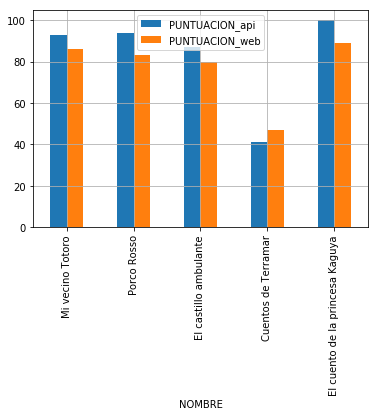

In [6]:
# COMPARAMOS LOS RESULTADOS CON UN DIAGRAMA DE BARRAS Y OBSERVAMOS QUE 
# EN 4 DE LAS 5 PELICUALAS SE HAN PUESTO MÁS PUNTUACIÓN A SUS PELIS 
# QUE LAS QUE LES HAN PUESTO EL PÚBLICO EN LA WEB IMDM

df_combined.plot(x='NOMBRE', y=['PUNTUACION_api', 'PUNTUACION_web'], kind="bar", grid=True)

df_combined.plot